In [69]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import GPyOpt

In [70]:
def normalize(data, norm_type):
    if norm_type == "minmax":
        for i in range(data.size()[1]):
            data[:,i] = (data[:,i]-data[:,i].min()) / (data[:,i].max()-data[:,i].min())
        return data
    elif norm_type == "zscore":
        for i in range(data.size()[1]):
            data[:,i] = (data[:,i]-data[:,i].mean()) / (data[:,i].std())
        return data
    elif norm_type == None:
        return data
    else:
        raise ValueError("Please choose a correct normalization type")
#Xnumtrain = torch.tensor(np.vstack([(Xnumtrain[:,i]-Xnumtrain[:,i].min()) / (Xnumtrain[:,i].max()-Xnumtrain[:,i].min()) for i in range(Xnumtrain.size()[1]) if "Tue elsker det her"])).view(-1,2)

def dataprep(data, catname, numname, norm_type = "zscore"):
    for category in categoricals:
        data[category] = data[category].astype("category")

    catname = []
    for i in range(len(categoricals)):
        catname.append(data[categoricals[i]].cat.codes.values)
    catname = torch.tensor(catname, dtype = torch.int64).T

    numname = np.stack([data[col].values for col in numericals], 1)
    numname = torch.tensor(numname, dtype=torch.float)


    normalize(numname, norm_type)

# Data Visualization and Pre-processing

In [71]:
url = "https://raw.githubusercontent.com/oskarwiese/fagprojekt/master/compas_propublica/compas-scores-two-years.csv"
data = pd.read_csv(url)
# Til at se på dataen 
#print(data.head)
#print(data.columns)

use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")

No GPU available.


In [72]:
df = data

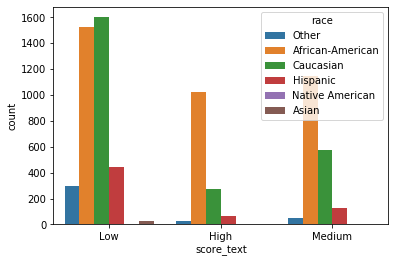

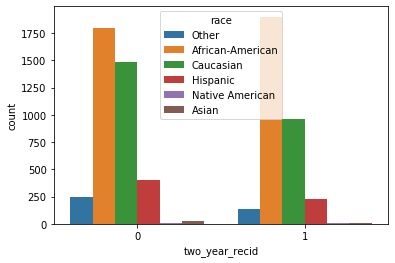

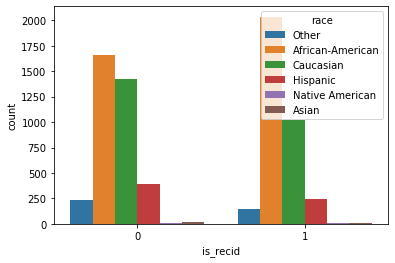

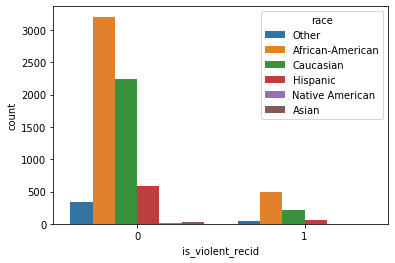

In [73]:
def is_plot():
    sb.countplot(x = "score_text", hue = "race", data = data)
    plt.show()

    sb.countplot(x = "two_year_recid", hue = "race", data = data)
    plt.show()
    sb.countplot(x = "is_recid", hue = "race", data = data)
    plt.show()
    sb.countplot(x = "is_violent_recid", hue = "race", data = data)
    plt.show()
is_plot()

In [74]:
categoricals = ["c_charge_degree", "race", "age_cat", "sex", "c_charge_degree"] # "r_charge_degree"    "two_year_recid"    "is_recid", "is_violent_recid"
numericals = ["age", "priors_count", "juv_fel_count", "juv_misd_count"] # "days_b_screening_arrest"
outputs = ["score_text"]

# Making the output binary
data[outputs] = data[outputs].replace('Low',0)
data[outputs] = data[outputs].replace('Medium',1)
data[outputs] = data[outputs].replace('High',1)
data[outputs] = data[outputs].astype("category")

294
450


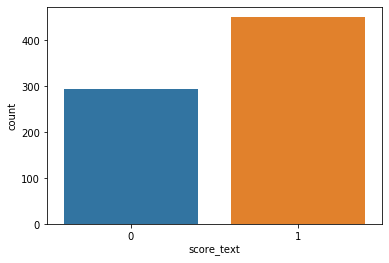

307
168


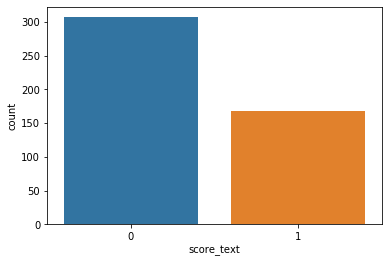

In [75]:
#dataprep(data, catname, numname, norm_type = "zscore")

# Changing the categorical values to categories
for category in categoricals:
    data[category] = data[category].astype("category")

# Preparing data for pytorch

# Converting the categorical values to a tensor
Xcat = []
for i in range(len(categoricals)):
    Xcat.append(data[categoricals[i]].cat.codes.values)
Xcat = torch.tensor(Xcat , dtype = torch.int64).T

#Converting the numerical values to a tensor
Xnum = np.stack([data[col].values for col in numericals], 1)
Xnum = torch.tensor(Xnum, dtype=torch.float)

# Converting the output to tensor
y = torch.tensor(data[outputs].values).flatten()

# Calculation of embedding sizes for the categorical values in the format (unique categorical values, embedding size (dimension of encoding))
categorical_column_sizes = [len(data[column].cat.categories) for column in categoricals]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]

# Train-test split
totalnumber = len(Xnum)
testnumber = int(totalnumber * 0.2)

Xcattrain = Xcat[:totalnumber - testnumber]
Xcattest = Xcat[totalnumber - testnumber:totalnumber]
Xnumtrain = Xnum[:totalnumber - testnumber]
Xnumtest = Xnum[totalnumber - testnumber:totalnumber]
ytrain = y[:totalnumber - testnumber]
ytest = y[totalnumber - testnumber:totalnumber]


# Make sure that we dont validate on training data to compare if the algorithm is biased


normalize(Xnumtrain, "zscore");
normalize(Xnumtest, "zscore");

df = data[totalnumber - testnumber:totalnumber]
black_data = df[df["race"]=="African-American"]
white_data = df[df["race"]=="Caucasian"]

sb.countplot(x = "score_text", data = black_data)
print(len(black_data[black_data["score_text"] == 0]))
print(len(black_data[black_data["score_text"] == 1]))
plt.show()
sb.countplot(x = "score_text", data = white_data)
print(len(white_data[white_data["score_text"] == 0]))
print(len(white_data[white_data["score_text"] == 1]))
plt.show()

# Neural Network

In [76]:
class Model(nn.Module):

    def __init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols + num_numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return nn.functional.softmax(x, dim = -1 )

# Train model on data

In [77]:
# Define and show the model
model = Model(categorical_embedding_sizes, 4, 2, [16,32,64,128,64], p=0.5)
if use_cuda:
    model.cuda()
print(model)

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(6, 3)
    (2): Embedding(3, 2)
    (3): Embedding(2, 1)
    (4): Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (batch_norm_num): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=32, out_features=64, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.5, inplace=False)
    (1

In [78]:
# Loss function and optimization
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-6)

epoch:   1 loss: 0.70397663
epoch:  26 loss: 0.65336400
epoch:  51 loss: 0.61957073
epoch:  76 loss: 0.59571677
epoch: 101 loss: 0.59015858
epoch: 126 loss: 0.57552898
epoch: 151 loss: 0.57314080
epoch: 176 loss: 0.57063377
epoch: 201 loss: 0.56313097
epoch: 226 loss: 0.55811733
epoch: 251 loss: 0.55608761
epoch: 276 loss: 0.55763298
epoch: 300 loss: 0.5550153255
[[637 133]
 [236 436]]
              precision    recall  f1-score   support

           0       0.73      0.83      0.78       770
           1       0.77      0.65      0.70       672

    accuracy                           0.74      1442
   macro avg       0.75      0.74      0.74      1442
weighted avg       0.75      0.74      0.74      1442

0.7441054091539528


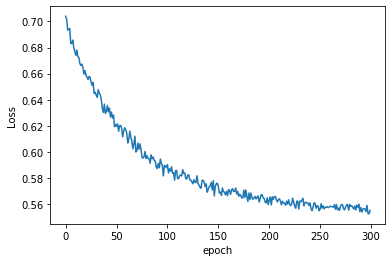

In [79]:
epochs = 300
aggregated_losses = []

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

model.train()
for i in range(epochs):
    i += 1
    y_pred = model(Xcattrain, Xnumtrain)
    single_loss = loss_function(y_pred, ytrain)
    aggregated_losses.append(single_loss)
    
    if i % 25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    
    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()
    
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
    


# Plot the loss over epocs
plt.plot(range(epochs), aggregated_losses)
plt.ylabel('Loss')
plt.xlabel('epoch');


# Predict on the test set
model.eval()
with torch.no_grad():
    y_val = model(Xcattest, Xnumtest)
    loss = loss_function(y_val, ytest)


y_val = np.argmax(y_val, axis=1)


print(confusion_matrix(ytest,y_val))
print(classification_report(ytest,y_val))
print(accuracy_score(ytest, y_val))

# Prep black and white

In [80]:
for category in categoricals:
    white_data[category] = white_data[category].astype("category")
    black_data[category] = black_data[category].astype("category")

Xcat_white, Xcat_black = [] ,[]
for i in range(len(categoricals)):
    Xcat_white.append(white_data[categoricals[i]].cat.codes.values)
    Xcat_black.append(black_data[categoricals[i]].cat.codes.values)
Xcat_white = torch.tensor(Xcat_white , dtype = torch.int64).T
Xcat_black = torch.tensor(Xcat_black , dtype = torch.int64).T 

Xnum_white = np.stack([white_data[col].values for col in numericals], 1)
Xnum_white = torch.tensor(Xnum_white, dtype=torch.float)
Xnum_black = np.stack([black_data[col].values for col in numericals], 1)
Xnum_black = torch.tensor(Xnum_black, dtype=torch.float)


normalize(Xnum_white, "zscore");
normalize(Xnum_black, "zscore");

# Confusion matrix for black/white

In [81]:
model.eval()
y_val_white = model(Xcat_white, Xnum_white)
y_val_white = np.argmax(y_val_white.detach().numpy(), axis = 1)
y_val_black = model(Xcat_black, Xnum_black)
y_val_black = np.argmax(y_val_black.detach().numpy(), axis = 1)

# Ground truth of recidivism from dataset
y_white = torch.tensor(white_data["two_year_recid"].values).flatten()
y_black = torch.tensor(black_data["two_year_recid"].values).flatten()

print("Confussion matrix for the white:")
conf_white = confusion_matrix( y_white, y_val_white)
print(conf_white)
print(conf_white / conf_white.astype(np.float).sum(axis=1))
print()
print("Confussion matrix for the black:")
conf_black = confusion_matrix( y_black, y_val_black)
print(conf_black)
print(conf_black / conf_black.astype(np.float).sum(axis=1))

Confussion matrix for the white:
[[210  87]
 [ 69 109]]
[[0.70707071 0.48876404]
 [0.23232323 0.61235955]]

Confussion matrix for the black:
[[272  77]
 [189 206]]
[[0.77936963 0.19493671]
 [0.54154728 0.52151899]]


# Random Forest

In [19]:
# Define the model and fit it to the data
def RandomForest(datatrain, datatest, ytrain, ytest, n_estimators = 53, max_depth = 14, max_features = "log2", criterion = "entropy", show_acc = True):
    forestModel = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, max_features = max_features, criterion = criterion)
    forestModel.fit(datatrain, ytrain)

    # Predict on the test set
    forestPreds = forestModel.predict(datatest)

    forestProbs = forestModel.predict_proba(datatest)[:, 1]

    if show_acc:
        print("Predicted no recidivism: ", len(forestPreds[forestPreds == 0]))
        print("Predicted recidivism: ", len(forestPreds[forestPreds == 1]))

        print("Accuracy of the random forest model: ", len(forestPreds[torch.tensor(forestPreds, dtype = torch.int64) == ytest]) / len(forestPreds))

RandomForest(Xcattrain, Xcattest, ytrain, ytest, n_estimators = 53, max_depth = 14, max_features = "log2", criterion = "entropy", show_acc = True)

# Baysian Optimization

In [ ]:
## define the domain of the considered parameters
n_estimators = tuple(np.arange(1,301,1, dtype= np.int))
# print(n_estimators)
max_depth = tuple(np.arange(1,110,1, dtype= np.int))
# max_features = ('log2', 'sqrt', None)
max_features = (0, 1)
# criterion = ('gini', 'entropy')
criterion = (0, 1)


# define the dictionary for GPyOpt
domain = [{'n_estimators': 'var_1',  'type': 'discrete',     'domain': n_estimators},
          {'max_depth': 'var_2',     'type': 'discrete',     'domain': max_depth},
          {'max_features': 'var_3',  'type': 'categorical',  'domain': max_features},
          {'criterion': 'var_4',     'type': 'categorical',  'domain': criterion}]


## we have to define the function we want to maximize --> validation accuracy, 
## note it should take a 2D ndarray but it is ok that it assumes only one point
## in this setting
def objective_function(x): 
    print(x)
    # we have to handle the categorical variables that is convert 0/1 to labels
    # log2/sqrt and gini/entropy
    
    param = x[0]
    
    if param[2] == 0:
        var_3 = "log2"
    else:
        var_3 = "sqrt"
    
    if param[3] == 0:
        var_4 = "gini"
    else:
        var_4 = "entropy"
        
        
#fit the model
    model = RandomForestClassifier(n_estimators = int(param[0]), criterion = var_4, max_depth = int(param[1]), max_features = var_3)
    model.fit(Xcattrain, ytrain)
    forestPreds = model.predict(Xcattest)
    accuracy = len(forestPreds[torch.tensor(forestPreds, dtype = torch.int64) == ytest]) / len(forestPreds)
    return accuracy


opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                              domain = domain,         # box-constrains of the problem
                                              acquisition_type = "EI",      # Select acquisition function MPI, EI, LCB
                                             )
opt.acquisition.exploration_weight=.1

opt.run_optimization(max_iter = 100) 


x_best = opt.X[np.argmin(opt.Y)]
print("The best parameters obtained: n_estimators=" + str(x_best[0]) + ", max_depth=" + str(x_best[1]) + ", max_features=" + str(
    x_best[2])  + ", criterion=" + str(
    x_best[3]))

[[290.   2.   0.   1.]]
[[170.  73.   0.   1.]]
[[160.  40.   1.   1.]]
[[27. 62.  0.  0.]]
[[55. 59.  1.  0.]]
[[290.   2.   0.   1.]]
[[289.   2.   0.   1.]]
[[300.  54.   1.   0.]]
[[249.   1.   0.   0.]]
[[265.   1.   1.   0.]]
[[290.   1.   0.   0.]]
[[259.   1.   0.   1.]]
[[232.   1.   1.   1.]]
[[1. 1. 1. 1.]]
[[32.  1.  1.  1.]]
[[17.  1.  1.  0.]]
[[65.  1.  0.  0.]]
[[51.  1.  1.  0.]]
[[289.   1.   1.   1.]]
[[275.   1.   0.   1.]]
[[215.   1.   0.   0.]]
[[225.   1.   0.   0.]]
[[92.  1.  1.  0.]]
[[115.   1.   0.   0.]]
[[103.   1.   0.   0.]]
[[177.   1.   1.   0.]]
[[193.   1.   1.   0.]]
[[146.   1.   1.   0.]]
[[109.   1.   1.   1.]]
[[11.  1.  0.  1.]]
[[1. 1. 0. 0.]]
[[159.   1.   0.   1.]]
[[133.   1.   0.   1.]]
[[82.  1.  0.  1.]]
[[219.   1.   1.   0.]]
[[68.  1.  1.  1.]]
[[184.   1.   0.   1.]]
[[150.   1.   0.   0.]]
[[204.   1.   1.   1.]]
[[290.   1.   0.   1.]]
[[76.  1.  1.  0.]]
[[263.   8.   0.   1.]]
[[108. 109.   0.   0.]]
[[229. 109.   0.   0.]]
[[  